In [5]:
#각각의 요소별 생존 확률을 구한다.
#각 성별에 대한 생존 확률
#각 클래스에 대한 생존 확률

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 10



#plt.rcParams['font.family'] = 'AppleGothic'  # 맥용 폰트
#plt.rcParams['font.size'] = 10


In [6]:
#데이터 읽기
df = pd.read_csv('train.csv')
#데이터 프레임의 요약 정보 결측치 확인 #나이 177개 결측치, Cabin 687개 결측치, Embarked 2개 결측치
print(df.isnull().sum())
df.info() #dtypes: float64(2), int64(5), object(5)
print(df.head())




train_df = pd.read_csv('train.csv') #학습 파일
test_df = pd.read_csv('test.csv') #평가 파일



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
   

In [7]:
#데이터 프레임 출력
print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [8]:
# 전체 승객 수
PassengerId = df['PassengerId'].count()
print(f'전체 승객 수 : {PassengerId}')
# 전체 승객 중 생존자 수
print(f'전체 승객 중 생존자 수 : {df["Survived"].sum()}')


전체 승객 수 : 891
전체 승객 중 생존자 수 : 342


전체 생존자 비율 : 0.3838383838383838
생존자 중 여자 생존자 비율: 0.6812865497076024
생존자 중 남자 생존자 비율: 0.31871345029239767


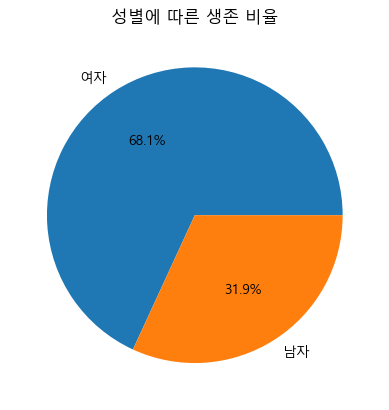

In [9]:
#전체 생존자 비율 생존자 = 1, 사망자 = 0
print(f"전체 생존자 비율 : {df['Survived'].mean()}")

# 생존자만 선택
survived = df[df['Survived'] == 1]
# 사망자만 선택
dead = df[df['Survived'] == 0]

# 생존자 중 남자 여자 비율
female_survived = survived[survived['Sex'] == 'female']
male_survived = survived[survived['Sex'] == 'male']

female_survived_ratio = len(female_survived)/len(survived)
male_survived_ratio = len(male_survived)/len(survived)

print('생존자 중 여자 생존자 비율:', female_survived_ratio)
print('생존자 중 남자 생존자 비율:', male_survived_ratio)

# 성별에 따른 생존 비율 그래프
plt.pie([female_survived_ratio, male_survived_ratio], labels=['여자', '남자'], autopct='%1.1f%%')
plt.title('성별에 따른 생존 비율')
plt.show()

전체 사망자 비율 : 0.6161616161616161
전체 사망자 중 여자 사망자  : 0.14754098360655737
전체 사망자 중 남자 사망자  : 0.8524590163934426


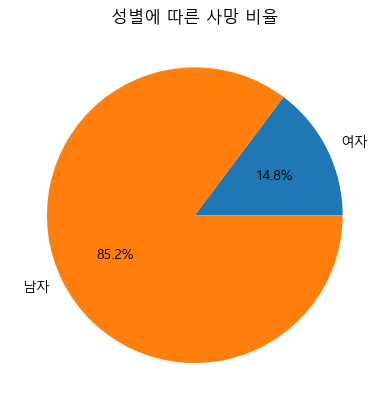

In [10]:
#전체 사망지 비율
print(f"전체 사망자 비율 : {1 - df['Survived'].mean()}")
#

female_dead = dead[dead['Sex'] == 'female']
male_dead = dead[dead['Sex'] == 'male']

female_dead_ratio = len(female_dead)/len(dead)
male_dead_ratio = len(male_dead)/len(dead)

print('전체 사망자 중 여자 사망자  :', len(female_dead)/len(dead))
print('전체 사망자 중 남자 사망자  :', len(male_dead)/len(dead))
#성별에 따른 사망 비율
plt.pie([female_dead_ratio,male_dead_ratio], labels=['여자', '남자'], autopct='%1.1f%%')
plt.title('성별에 따른 사망 비율')
plt.show()


등급별 생존 확률 
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


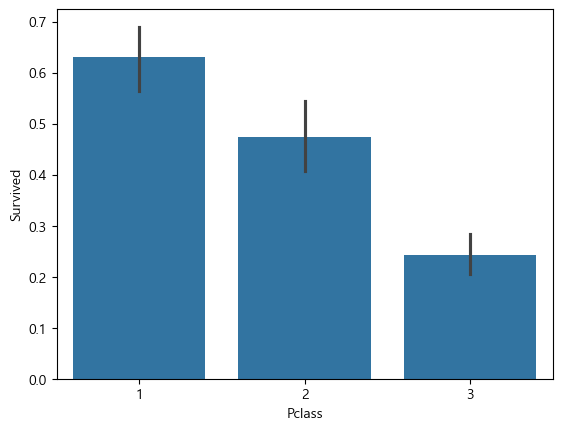

In [11]:
#좌석 등급별 생존자 비율
#좌석 등급에 따라 생존자 비율이 달라지는지 확인 등급은 총 3가지가 있음

print(f"등급별 생존 확률 \n{df.groupby('Pclass')['Survived'].mean()}")
#좌석 등급별 생존자 비율 시각화
sns.barplot(data=df, x='Pclass', y='Survived')
plt.show()
#그래프로 알 수 있는 것은 1등급이 생존률이 높고 3등급이 낮다
#3등급의 경우 생존률이 25%도 되지 않는다.
#1등급의 경우 생존률이 63%에 달한다.
#좌석 등급에 따라 생존률이 달라지는 것을 알 수 있다.




In [12]:
#등급별 티켓 가격 

Fare_class = df.groupby('Pclass')['Fare'].mean()
print(Fare_class)


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64


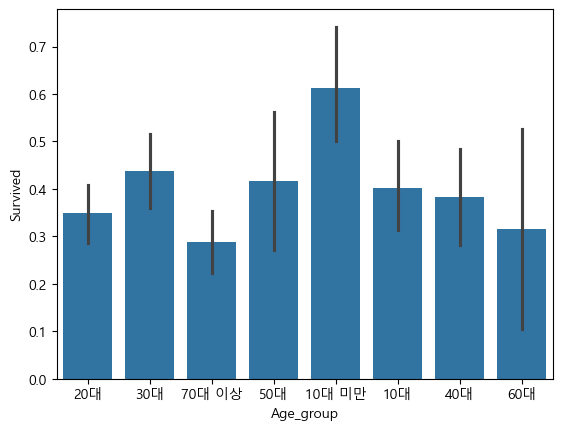

In [13]:
#나이에 따른 생존 확률 (결측치 제거 전전)
#나이대를 구분 10대 미만 10대 20대 30대 40대 50대 60대 70대 이상

def age_group(age):
    if age < 10:
        return '10대 미만'
    elif age < 20:
        return '10대'
    elif age < 30:
        return '20대'
    elif age < 40:
        return '30대'
    elif age < 50:
        return '40대'
    elif age < 60:
        return '50대'
    elif age < 70:
        return '60대'
    else:
        return '70대 이상'
    
#승객 나이 통계 확인하기
df['Age'].describe()
#승객 나이에 따라 분류하기
df['Age_group'] = df['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
df.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=df)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29320\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


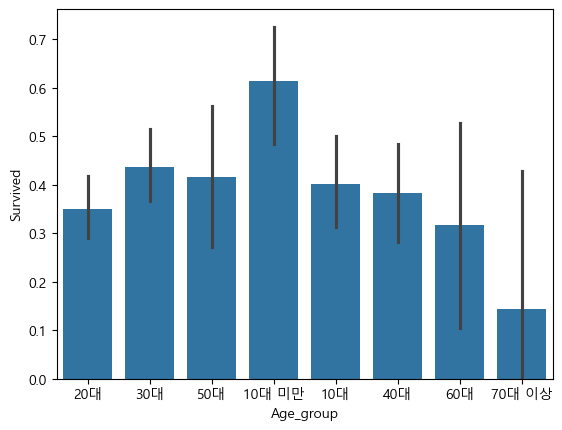

In [14]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29320\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


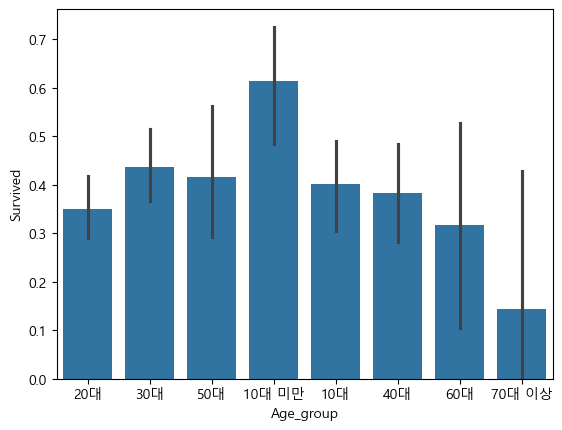

In [15]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29320\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


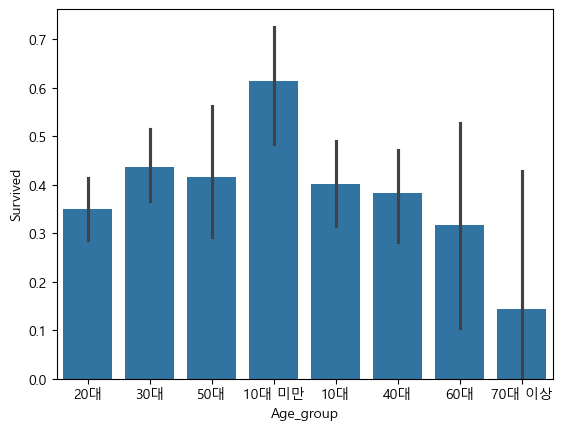

In [16]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29320\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


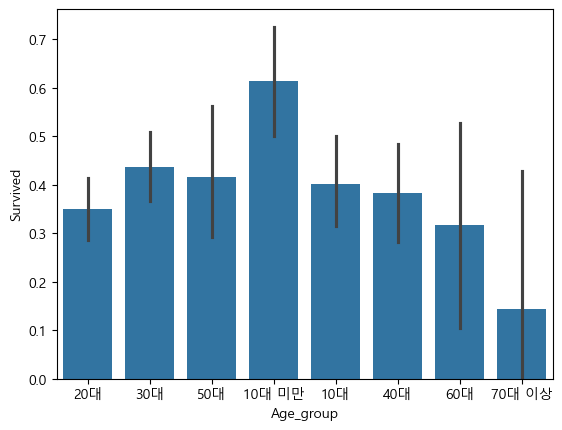

In [17]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29320\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


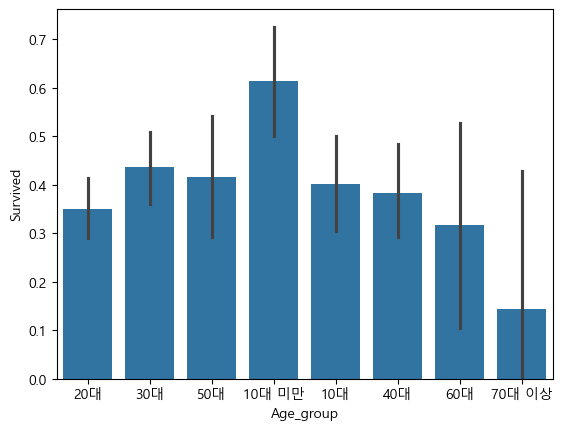

In [18]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29320\2678877980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)


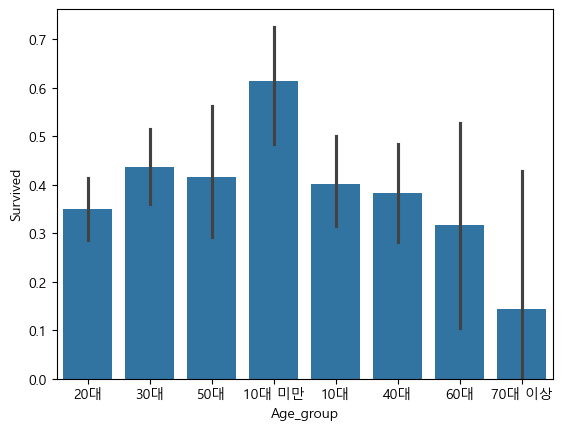

In [19]:
#나이 데이터 결측치 처리

age_null_delete = df.dropna(subset=['Age'])

#승객 나이 통계 확인하기
age_null_delete['Age'].describe()
#승객 나이에 따라 분류하기
age_null_delete['Age_group'] = age_null_delete['Age'].apply(age_group)
#승객 나이에 따른 생존 확률
age_null_delete.groupby('Age_group')['Survived'].mean()
#승객 나이에 따른 생존 확률 시각화
sns.barplot(x='Age_group', y='Survived', data=age_null_delete)
plt.show()

In [20]:
#운임비용에 따른 생존율
#운임비용이 높으면 생존율이 높을지에 대해서 Fare를 기준으로 분석
#

df['Fare'].describe()
#5
df['FareBand'] = pd.qcut(df['Fare'], 5)
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
#200불 이상은 생존율이 높다.

'''print(df['Fare'].min()) #요금에 이상치 있는지 확인 시 0원이 있음

print(df['Fare'].max())'''

df_sorted = df.sort_values(by='Fare', ascending=False)
high_10 = df_sorted.head(10)
low_10 = df_sorted.tail(10)

print(high_10)
print(low_10)



     PassengerId  Survived  Pclass                                   Name  \
258          259         1       1                       Ward, Miss. Anna   
737          738         1       1                 Lesurer, Mr. Gustave J   
679          680         1       1     Cardeza, Mr. Thomas Drake Martinez   
88            89         1       1             Fortune, Miss. Mabel Helen   
27            28         0       1         Fortune, Mr. Charles Alexander   
341          342         1       1         Fortune, Miss. Alice Elizabeth   
438          439         0       1                      Fortune, Mr. Mark   
311          312         1       1             Ryerson, Miss. Emily Borie   
742          743         1       1  Ryerson, Miss. Susan Parker "Suzette"   
118          119         0       1               Baxter, Mr. Quigg Edmond   

        Sex   Age  SibSp  Parch    Ticket      Fare            Cabin Embarked  \
258  female  35.0      0      0  PC 17755  512.3292              NaN   

C:\Users\user\AppData\Local\Temp\ipykernel_29320\1390922172.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


탑승 항구 별 생존 확률 
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


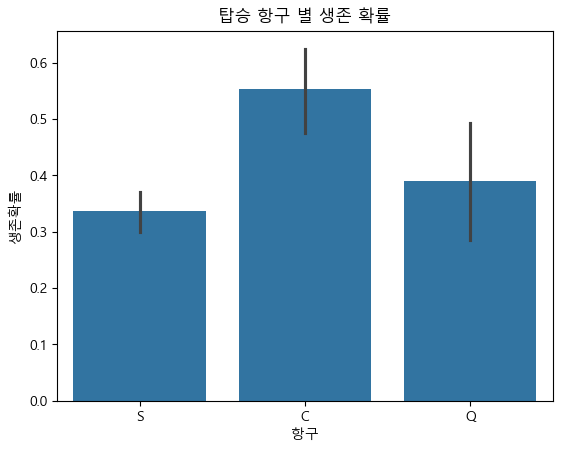

항구 별 가격 평균
Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64
항구 별 티켓 등급
Embarked
C    1.886905
Q    2.909091
S    2.350932
Name: Pclass, dtype: float64


In [21]:
#탑승 항구에 따라 생존률이 달라지는지 확인


print(f"탑승 항구 별 생존 확률 \n{df.groupby('Embarked')['Survived'].mean()}")
#좌석 등급별 생존자 비율 시각화
sns.barplot(data=df, x='Embarked', y='Survived')
plt.title('탑승 항구 별 생존 확률')
plt.xlabel('항구')
plt.ylabel('생존확률')
plt.show()

print(f"항구 별 가격 평균\n{df.groupby('Embarked')['Fare'].mean()}" )
print(f"항구 별 티켓 등급\n{df.groupby('Embarked')['Pclass'].mean()}")

In [22]:
# Sibsp 과 Parch 0인 경우 혼자 탑승
# 1이상인 경우 동승자 있음

alone = df[df['SibSp'] == 0]
alone = alone[alone['Parch'] == 0]
print(alone['Survived'].value_counts())


#동승자가 있는 경우 생존률이 더 높은지 확인
#동승자가 있는 사람
Sibsp_Parch = df[df['SibSp'] > 0]
Sibsp_parch = Sibsp_Parch[Sibsp_Parch['Parch'] > 0]
print(Sibsp_Parch['Survived'].value_counts())

#동승자가 있는 경우 생존률이 더 높음

Survived
0    374
1    163
Name: count, dtype: int64
Survived
0    151
1    132
Name: count, dtype: int64


In [45]:
#모델 학습 시키기
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
X = df[['Pclass', 'Age', 'Sex', 'Fare']]
y = df['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('정확도 :', accuracy_score(y_test, y_pred))
print('혼동 행렬 :', confusion_matrix(y_test, y_pred))


정확도 : 0.7206703910614525
혼동 행렬 : [[86 19]
 [31 43]]


In [46]:
X = np.nan_to_num(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("LogisticRegression Accuracy:", accuracy_score(y_test, y_pred))



LogisticRegression Accuracy: 0.7150837988826816


In [47]:
model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("SVC Accuracy:", accuracy_score(y_test, y_pred))

SVC Accuracy: 0.6536312849162011
